------
**You cannot save any changes you make to this file, so please make sure to save it on your Google Colab drive or download it as a .ipynb file.**

------

 

Practical 1: Sentiment Detection in Movie Reviews
========================================



This practical concerns detecting sentiment in movie reviews. This is a typical NLP classification task.
In [this file](https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json) (80MB) you will find 1000 positive and 1000 negative **movie reviews**.
Each review is a **document** and consists of one or more sentences.

To prepare yourself for this practical, you should
have a look at a few of these texts to understand the difficulties of
the task: how might one go about classifying the texts? You will write
code that decides whether a movie review conveys positive or
negative sentiment.

Please make sure you have read the following paper:

>   Bo Pang, Lillian Lee, and Shivakumar Vaithyanathan
(2002). 
[Thumbs up? Sentiment Classification using Machine Learning
Techniques](https://dl.acm.org/citation.cfm?id=1118704). EMNLP.

Bo Pang et al. introduced the movie review sentiment
classification task, and the above paper was one of the first papers on
the topic. The first version of your sentiment classifier will do
something similar to Pang et al.'s system. If you have questions about it,
you should resolve you doubts as soon as possible with your TA.


**Advice**

Please read through the entire practical and familiarise
yourself with all requirements before you start coding or otherwise
solving the tasks. Writing clean and concise code can make the difference
between solving the assignment in a matter of hours, and taking days to
run all experiments.

## Environment

All code should be written in **Python 3**. 
This is the default in Google Colab.

In [1]:
!python --version

Python 3.9.7


If you want to run code on your own computer, then download this notebook through `File -> Download .ipynb`.
The easiest way to
install Python is through downloading
[Anaconda](https://www.anaconda.com/download). 
After installation, you can start the notebook by typing `jupyter notebook filename.ipynb`.
You can also use an IDE
such as [PyCharm](https://www.jetbrains.com/pycharm/download/) to make
coding and debugging easier. It is good practice to create a [virtual
environment](https://docs.python.org/3/tutorial/venv.html) for this
project, so that any Python packages don’t interfere with other
projects. 
 

**Learning Python 3**

If you are new to Python 3, you may want to check out a few of these resources:
- https://learnxinyminutes.com/docs/python3/
- https://www.learnpython.org/
- https://docs.python.org/3/tutorial/

In [2]:
import math
import os
import sys
from subprocess import call
from nltk import FreqDist
from nltk.util import ngrams
from nltk.stem.porter import PorterStemmer
import sklearn as sk
# from google.colab import drive
import pickle
import json
from collections import Counter
import requests
import matplotlib.pyplot as plt
import numpy as np

## Loading the data

**Download the sentiment lexicon and the movie reviews dataset.**

In [3]:
# download sentiment lexicon
# !wget https://gist.githubusercontent.com/bastings/d6f99dcb6c82231b94b013031356ba05/raw/f80a0281eba8621b122012c89c8b5e2200b39fd6/sent_lexicon

# download review data
# !wget https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json

**Load the movie reviews.**

Each word in a review comes with its part-of-speech tag. For documentation on POS-tags, see https://catalog.ldc.upenn.edu/docs/LDC99T42/tagguid1.pdf.


In [4]:
# file structure:
# [
#  {"cv": integer, "sentiment": str, "content": list} 
#  {"cv": integer, "sentiment": str, "content": list} 
#   ..
# ]
# where `content` is a list of sentences, 
# with a sentence being a list of (token, pos_tag) pairs.


with open("reviews.json", mode="r", encoding="utf-8") as f:
    reviews = json.load(f)

print("Total number of reviews:", len(reviews), '\n')

def print_sentence_with_pos(s):
    print(" ".join("%s/%s" % (token, pos_tag) for token, pos_tag in s))

for i, r in enumerate(reviews):
    print(r["cv"], r["sentiment"], len(r["content"]))  # cv, sentiment, num sents
    print_sentence_with_pos(r["content"][0])
    if i == 4: 
        break
    
c = Counter()
for review in reviews:
    for sentence in review["content"]:
        for token, pos_tag in sentence:
            c[token.lower()] += 1

print("\nNumber of word types:", len(c))
print("Number of word tokens:", sum(c.values()))

print("\nMost common tokens:")
for token, count in c.most_common(20):
      print("%10s : %8d" % (token, count))

Total number of reviews: 2000 

0 NEG 29
Two/CD teen/JJ couples/NNS go/VBP to/TO a/DT church/NN party/NN ,/, drink/NN and/CC then/RB drive/NN ./.
1 NEG 11
Damn/JJ that/IN Y2K/CD bug/NN ./.
2 NEG 24
It/PRP is/VBZ movies/NNS like/IN these/DT that/WDT make/VBP a/DT jaded/JJ movie/NN viewer/NN thankful/JJ for/IN the/DT invention/NN of/IN the/DT Timex/NNP IndiGlo/NNP watch/NN ./.
3 NEG 19
QUEST/NN FOR/IN CAMELOT/NNP ``/`` Quest/NNP for/IN Camelot/NNP ''/'' is/VBZ Warner/NNP Bros./NNP '/POS first/JJ feature-length/JJ ,/, fully-animated/JJ attempt/NN to/TO steal/VB clout/NN from/IN Disney/NNP 's/POS cartoon/NN empire/NN ,/, but/CC the/DT mouse/NN has/VBZ no/DT reason/NN to/TO be/VB worried/VBN ./.
4 NEG 38
Synopsis/NNPS :/: A/DT mentally/RB unstable/JJ man/NN undergoing/VBG psychotherapy/NN saves/VBZ a/DT boy/NN from/IN a/DT potentially/RB fatal/JJ accident/NN and/CC then/RB falls/VBZ in/IN love/NN with/IN the/DT boy/NN 's/POS mother/NN ,/, a/DT fledgling/NN restauranteur/NN ./.

Number of wo

# Lexicon-based approach (3.5pts)



A traditional approach to classify documents according to their sentiment is the lexicon-based approach. To implement this approach, you need a **sentiment lexicon**, i.e., a list of words annotated with a sentiment label (e.g., positive and negative, or a score from 0 to 5).

In this practical, you will use the sentiment
lexicon released by Wilson et al. (2005).

> Theresa Wilson, Janyce Wiebe, and Paul Hoffmann
(2005). [Recognizing Contextual Polarity in Phrase-Level Sentiment
Analysis](http://www.aclweb.org/anthology/H/H05/H05-1044.pdf). HLT-EMNLP.

Pay attention to all the information available in the sentiment lexicon. The field *word1* contains the lemma, *priorpolarity* contains the sentiment label (positive, negative, both, or neutral), *type* gives you the magnitude of the word's sentiment (strong or weak), and *pos1* gives you the part-of-speech tag of the lemma. Some lemmas can have multiple part-of-speech tags and thus multiple entries in the lexicon. The path of the lexicon file is `"sent_lexicon"`.


In [5]:
with open("sent_lexicon", mode="r", encoding="utf-8") as f:
    line_cnt = 0
    for line in f:
        print(line.strip())
        line_cnt += 1
        if line_cnt > 4:
            break

type=weaksubj len=1 word1=abandoned pos1=adj stemmed1=n priorpolarity=negative
type=weaksubj len=1 word1=abandonment pos1=noun stemmed1=n priorpolarity=negative
type=weaksubj len=1 word1=abandon pos1=verb stemmed1=y priorpolarity=negative
type=strongsubj len=1 word1=abase pos1=verb stemmed1=y priorpolarity=negative
type=strongsubj len=1 word1=abasement pos1=anypos stemmed1=y priorpolarity=negative


Lexica such as this can be used to solve
the classification task without using Machine Learning. For example, one might look up every word $w_1 ... w_n$ in a document, and compute a **binary score**
$S_{binary}$ by counting how many words have a positive or a
negative label in the sentiment lexicon $SLex$.

$$S_{binary}(w_1 w_2 ... w_n) = \sum_{i = 1}^{n}\text{sign}(SLex\big[w_i\big])$$

where $\text{sign}(SLex\big[w_i\big])$ refers to the polarity of $w_i$.

**Threshold.** On average, there are more positive than negative words per review (~7.13 more positive than negative per review) to take this bias into account you should use a threshold of **8** (roughly the bias itself) to make it harder to classify as positive.

$$
\text{classify}(S_{binary}(w_1 w_2 ... w_n)) = \bigg\{\begin{array}{ll}
        \text{positive} & \text{if } S_{binary}(w_1w_2...w_n) > threshold\\
        \text{negative} & \text{otherwise}
        \end{array}
$$


#### (Q1.1) Implement this approach and report its classification accuracy. (1 pt)

In [6]:
# Basic common helpers

# mapping from polarity to sign
POLARITY_TO_SIGN = {
    "negative": -1,
    "positive": 1,
    "neutral": 0,
    "both": 0,
}

# mapping from magnitude (str) to magnitude (value - float)
MAGNITUDE_TO_VALUE = {
    "strongsubj": 2.0,
    "weaksubj": 1.0,
}


def pos_tag_upenn_to_desc(tag):
    """Returns the description of given POS tag in UPenn notation."""

    if tag.startswith("VB"):
        desc = "verb"
    elif tag.startswith("NN"):
        desc = "noun"
    elif tag.startswith("JJ"):
        desc = "adj"
    elif tag.startswith("RB"):
        desc = "adverb"
    else:
        desc = "anypos"
    
    return desc


def check_valid_document(document):
    """Checks if a given document is valid (structurally)."""
    assert isinstance(document, list)
    for sent in document:
        assert isinstance(sent, list)
        for (word, tag) in sent:
            assert isinstance(word, str)
            assert isinstance(tag, str)


def document_score(lexicon, document, check_document=False):
    """Computes document score based on the given lexicon."""
    
    # check if the document is a valid input
    if check_document:
        check_valid_document(document)
    
    score = 0.0

    # loop over sentences in document
    for sent in document:
        # loop over words in sentence
        for (word, tag) in sent:
            word = word.lower()
            tag_desc = pos_tag_upenn_to_desc(tag)
            key = f"{word}/{tag_desc}"
            if key in lexicon:
                score += lexicon[key]
    
    return score


def classify_by_lexical_score(lexicon, document, threshold):
    """Classifies a given document based on score computed via given lexicon."""
    return int(document_score(lexicon, document) > threshold)

In [7]:
def word_binary_score(polarity):
    """Computes score for a word with given polatiy."""
    return POLARITY_TO_SIGN[polarity]


# construct binary lexicon
binary_lexicon = dict()
with open("sent_lexicon", mode="r", encoding="utf-8") as f:
    for line in f:
        fields = line.strip().split(" ")
        fields = {ele.split("=")[0]:ele.split("=")[1] for ele in fields}
        
        key = f"{fields['word1']}/{fields['pos1']}"
        value = word_binary_score(fields["priorpolarity"])
        binary_lexicon[key] = value

In [8]:
# token_results should be a list of binary indicators; for example [1, 0, 1, ...] 
# where 1 indicates a correct classification and 0 an incorrect classification.

token_results = []

for r in reviews:
    y_true = int(r["sentiment"] == "POS")
    y_pred = classify_by_lexical_score(binary_lexicon, r["content"], threshold=8)
    token_results.append(int(y_true == y_pred))

token_accuracy = np.mean(token_results)

print("Accuracy: %0.2f" % token_accuracy)

Accuracy: 0.63


As the sentiment lexicon also has information about the **magnitude** of
sentiment (e.g., *“excellent"* has the same sentiment _polarity_ as *“good"* but it has a higher magnitude), we can take a more fine-grained approach by adding up all
sentiment scores, and deciding the polarity of the movie review using
the sign of the weighted score $S_{weighted}$.

$$S_{weighted}(w_1w_2...w_n) = \sum_{i = 1}^{n}SLex\big[w_i\big]$$


Make sure you define an appropriate threshold for this approach.

#### (Q1.2) Now incorporate magnitude information and report the classification accuracy. Don't forget to use the threshold. (1pt)

In [9]:
def word_magnitude_score(magnitude, polarity):
    """Computes score for a word with given polarity and magnitude."""
    assert polarity in ["positive", "negative", "both", "neutral"]
    assert magnitude in ["strongsubj", "weaksubj"]
    
    magnitude = MAGNITUDE_TO_VALUE[magnitude]

    score = POLARITY_TO_SIGN[polarity] * magnitude
    return score


# construct magnitude lexicon
magnitude_lexicon = dict()
with open("sent_lexicon", mode="r", encoding="utf-8") as f:
    for line in f:
        fields = line.strip().split(" ")
        fields = {ele.split("=")[0]:ele.split("=")[1] for ele in fields}
        
        key = f"{fields['word1']}/{fields['pos1']}"
        magnitude_lexicon[key] = word_magnitude_score(fields["type"], fields["priorpolarity"])

In [10]:
magnitude_results = []

for r in reviews:
    y_true = int(r["sentiment"] == "POS")
    y_pred = classify_by_lexical_score(magnitude_lexicon, r["content"], threshold=8.0)
    magnitude_results.append(int(y_true == y_pred))

magnitude_accuracy = np.mean(magnitude_results)

print("Accuracy: %0.2f" % magnitude_accuracy)

Accuracy: 0.66


#### (Q.1.4) Make a barplot of the two results (0.5pt)

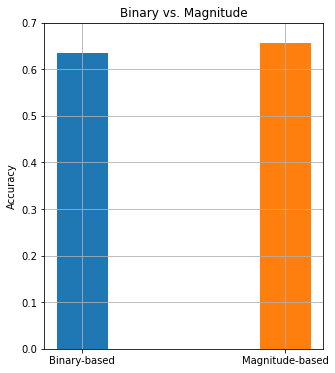

In [11]:
# YOUR CODE HERE

width = 0.25
height = 1.0

fig, ax = plt.subplots(figsize=(5, 6))
binary_based_bar = ax.bar(0, token_accuracy, width, label='Binary-based')
magnitude_based_bar = ax.bar(1, magnitude_accuracy, width, label='Magnitude-based')
ax.grid()

plt.ylabel('Accuracy')
plt.title('Binary vs. Magnitude')
plt.ylim(0, 0.7)
plt.xticks((0, 1), ('Binary-based', 'Magnitude-based'))
plt.show()

#### (Q1.3) A better threshold (1pt)
Above we have defined a threshold to account for an inherent bias in the dataset: there are more positive than negative words per review.
However, that threshold does not take into account *document length*. Explain why this is a problem and implement an alternative way to compute the threshold.

Since our choice of threshold is independent of document length, it is problematic because longer documents will naturally have more words and could skew the score to highly positive or highly negative value by the virtue of its length.

In [12]:
magnitude_results = []

for r in reviews:
    y_true = int(r["sentiment"] == "POS")
    num_words_in_document = np.sum([len(x) for x in r["content"]])
    y_pred = classify_by_lexical_score(magnitude_lexicon, r["content"], threshold=(8000.0 / num_words_in_document))
    magnitude_results.append(int(y_true == y_pred))

magnitude_accuracy = np.mean(magnitude_results)

print("Accuracy: %0.2f" % magnitude_accuracy)

Accuracy: 0.63


# Naive Bayes (9.5pts)


Your second task is to program a simple Machine Learning approach that operates
on a simple Bag-of-Words (BoW) representation of the text data, as
described by Pang et al. (2002). In this approach, the only features we
will consider are the words in the text themselves, without bringing in
external sources of information. The BoW model is a popular way of
representing texts as vectors, making it
easy to apply classical Machine Learning algorithms on NLP tasks.
However, the BoW representation is also very crude, since it discards
all information related to word order and grammatical structure in the
original text—as the name suggests.

## Writing your own classifier (4pts)

Write your own code to implement the Naive Bayes (NB) classifier. As
a reminder, the Naive Bayes classifier works according to the following
equation:
$$\hat{c} = \operatorname*{arg\,max}_{c \in C} P(c|\bar{f}) = \operatorname*{arg\,max}_{c \in C} P(c)\prod^n_{i=1} P(f_i|c)$$
where $C = \{ \text{POS}, \text{NEG} \}$ is the set of possible classes,
$\hat{c} \in C$ is the most probable class, and $\bar{f}$ is the feature
vector. Remember that we use the log of these probabilities when making
a prediction:
$$\hat{c} = \operatorname*{arg\,max}_{c \in C} \Big\{\log P(c) + \sum^n_{i=1} \log P(f_i|c)\Big\}$$

You can find more details about Naive Bayes in [Jurafsky &
Martin](https://web.stanford.edu/~jurafsky/slp3/). You can also look at
this helpful
[pseudo-code](https://nlp.stanford.edu/IR-book/html/htmledition/naive-bayes-text-classification-1.html).

*Note: this section and the next aim to put you in a position to replicate
    Pang et al.'s Naive Bayes results. However, your numerical results
    will differ from theirs, as they used different data.*

**You must write the Naive Bayes training and prediction code from
scratch.** You will not be given credit for using off-the-shelf Machine
Learning libraries.

The data contains the text of the reviews, where each document consists
of the sentences in the review, the sentiment of the review and an index
(cv) that you will later use for cross-validation. The
text has already been tokenised and POS-tagged for you. Your algorithm
should read in the text, **lowercase it**, store the words and their
frequencies in an appropriate data structure that allows for easy
computation of the probabilities used in the Naive Bayes algorithm, and
then make predictions for new instances.


#### (Q2.1) Unseen words (1pt)
The presence of words in the test dataset that
have not been seen during training can cause probabilities in the Naive Bayes classifier to equal $0$.
These can be words which are unseen in both positive and negative training reviews (case 1), but also words which are seen in reviews _of only one sentiment class_ in the training dataset (case 2). In both cases, **you should skip these words for both classes**.  What would be the problem instead with skipping words only for one class in case 2? 

Note that, our estimates for required probabilities are as follows:
$$
p(c) = \frac{N_{c}}{N}, \\
p(w| c) = \frac{T_{wc}}{\sum_{w' \in \mathbf{V}}T_{w'c}}
$$

where $N$ is the total number of documents, $N_c$ is the number of documents in class $c$, $\mathbf{V}$ denotes the vocabulary, $w$ denotes a given word, $T_{wc}$ denotes the frequency of word $w$ occuring in training documents in class $c$.

If we consider case 2, suppose we encounter a word $w$ that occurs in positive reviews but not in negative reviews. Then, by definition, 
$$
p(f | c = 0) = \frac{T_{w0}}{\sum_{w' \in \mathbf{V}}T_{w'0}} = 0
$$
since $T_{w0} = 0$.

#### (Q2.2) Train your classifier on (positive and negative) reviews with cv-value 000-899, and test it on the remaining (positive and negative) reviews cv900–cv999.  Report results using classification accuracy as your evaluation metric. Your  features are the word vocabulary. The value of a feature is the count of that feature (word) in the document. (2pts)


In [52]:
# YOUR CODE HERE

from tqdm import tqdm

class NaiveBayesClassifier:
    """NB Classifier for text-classification based on BoW features."""

    def __init__(self, classes, smoothing_kappa=0, stemmer=None):
        self.classes = classes
        self.smoothing_kappa = smoothing_kappa
        
        # class-wise document counts
        self.class_priors = {k: 0.0 for k in self.classes}
        
        # class-wise vocabulary
        self.V = {k: Counter() for k in self.classes}
        self.net_words_per_class = {k: 0 for k in self.classes}
        self.common_words_per_class = {k: 0 for k in self.classes}
        self.vocab_size = 0
        
        # define stemmer
        self.stemmer = stemmer

    def create_class_wise_vocabulary(self, documents, labels):
        num_docs = len(documents)
        
        iterator = tqdm(
            range(num_docs),
            desc="Training",
            bar_format='{l_bar}{bar:20}{r_bar}{bar:-20b}',
        )
        for i in iterator:
            d, l = documents[i], labels[i]

            # update class counts
            self.class_priors[l] += (1.0 / num_docs)
            
            # get all words in the document (in lowercase)
            words = list(np.char.lower(np.concatenate(d)[:, 0]))
            
            # apply stemming to the words
            if self.stemmer is not None:
                words = list(map(self.stemmer.stem, words))
            
            words_unique, words_counts = np.unique(words, return_counts=True)
            word_freq_dict = dict(zip(words_unique, words_counts))
            
            # update class-wise vocabulary
            self.V[l].update(word_freq_dict)
        
        # get the net vocbulary
        vocab = set.union(*[set(self.V[c].keys()) for c in self.classes])
        self.vocab_size = len(vocab)
        
        # compute net size of class cluster (to be used while smoothing)
        for c in self.classes:
            self.net_words_per_class[c] = sum(list(self.V[c].values()))

        # compute common size of class cluster (to be used while smoothing)
        vocab_common = set.intersection(*[set(self.V[c].keys()) for c in self.classes])
        for c in self.classes:
            vocab_class = {w:v for w, v in self.V[c].items() if w in vocab_common}
            self.common_words_per_class[c] = sum(list(vocab_class.values()))

    def train(self, documents: list, labels: list):
        assert len(documents) == len(labels)
        assert set(np.unique(labels)) == set(self.classes)

        self.create_class_wise_vocabulary(documents, labels)

        print(f"Training finished with vocabulary of size {self.vocab_size}.")

    def check_word_in_vocab(self, word):
        for c in self.classes:
            if word not in self.V[c]:
                return False
        return True

    def predict(self, documents: list):
        """Predicts class label for each of the given documents."""
        num_docs = len(documents)
        
        iterator = tqdm(
            range(num_docs),
            desc="Evaluating",
            bar_format='{l_bar}{bar:20}{r_bar}{bar:-20b}',
        )
        predictions = []
        for i in iterator:
            d = documents[i]

            # get all words in the document (in lowercase)
            words = list(np.char.lower(np.concatenate(d)[:, 0]))
            if self.stemmer is not None:
                words = list(map(self.stemmer.stem, words))
            
            score = {k: np.log(self.class_priors[k]) for k in self.classes}
            for word in words:
                if self.check_word_in_vocab(word):
                    for c in self.classes:
                        count_word_in_c = self.V[c][word]
                        if self.smoothing_kappa > 0:
                            count_all_words_in_c = self.net_words_per_class[c]
                        else:
                            count_all_words_in_c = self.common_words_per_class[c]
                        nume = count_word_in_c + self.smoothing_kappa
                        deno = count_all_words_in_c + self.smoothing_kappa * self.vocab_size
                        score[c] += np.log(nume/deno)
        
            predicted_class = max(score, key=score.get)
            predictions.append(predicted_class)
        
        return predictions


def compute_accuracy(y_true: list, y_pred: list):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.mean((y_true == y_pred).astype(int))


def train_and_evaluate_clf(clf, train_idx, test_idx):
    train_documents = [reviews[i]["content"] for i in train_idx]
    train_labels = [reviews[i]["sentiment"] for i in train_idx]

    test_documents = [reviews[i]["content"] for i in test_idx]
    test_labels = [reviews[i]["sentiment"] for i in test_idx]
    
    # train the classifier
    clf.train(train_documents, train_labels)

    # compute train accuracy
    acc = compute_accuracy(train_labels, clf.predict(train_documents))
    print(f"Obtained accuracy using NaiveBayesClassifier on train set: {acc:.3f}")

    # compute test accuracy
    acc = compute_accuracy(test_labels, clf.predict(test_documents))
    print(f"Obtained accuracy using NaiveBayesClassifier on test set: {acc:.3f}")
    
    return acc


test = False
if test:
    # testing NB Classifier
    clf = NaiveBayesClassifier(classes=["POS", "NEG"])
    train_documents = [reviews[i]["content"] for i in range(len(reviews))]
    train_labels = [reviews[i]["sentiment"] for i in range(len(reviews))]

    clf.train(train_documents, train_labels)
    y_pred = clf.predict(train_documents)
    y_true = train_labels

    # compute train accuracy
    compute_accuracy(y_true, y_pred)

In [53]:
# split into training and testing data
cv = np.array([reviews[i]["cv"] for i in range(len(reviews))])
labels = np.array([reviews[i]["sentiment"] for i in range(len(reviews))])

train_idx = np.where(cv < 900)[0]
test_idx = np.where(cv >= 900)[0]

clf = NaiveBayesClassifier(classes=["POS", "NEG"])
train_and_evaluate_clf(clf, train_idx, test_idx)

Training: 100%|████████████████████| 1800/1800 [00:01<00:00, 946.46it/s]                                                                                 


Training finished with vocabulary of size 45348.


Evaluating: 100%|████████████████████| 1800/1800 [00:04<00:00, 413.28it/s]                                                                               


Obtained accuracy using NaiveBayesClassifier on train set: 0.947


Evaluating: 100%|████████████████████| 200/200 [00:00<00:00, 403.21it/s]                                                                                 

Obtained accuracy using NaiveBayesClassifier on test set: 0.835


0.835

#### (Q2.3) Would you consider accuracy to also be a good way to evaluate your classifier in a situation where 90% of your data instances are of positive movie reviews? (1pt)

Simulate this scenario by keeping the positive reviews
data unchanged, but only using negative reviews cv000–cv089 for
training, and cv900–cv909 for testing. Calculate the classification
accuracy, and explain what changed.

In general, I would not consider accuracy to be a good metric if my evaluation set is highly imbalanced since even if it predicts everything as positive, it can still achieve 90% accuracy.

> What is happening with NB in this case????

In [54]:
cond = ((cv < 90) * (labels == "NEG")) + ((labels == "POS") * (cv < 900))
train_idx = [i for i, value in enumerate(cond) if value]

cond = ((cv >= 900) * (cv <= 909) * (labels == "NEG")) + ((labels == "POS") * (cv >= 900))
test_idx = [i for i, value in enumerate(cond) if value]

clf = NaiveBayesClassifier(classes=["POS", "NEG"], smoothing_kappa=0.0)
train_and_evaluate_clf(clf, train_idx, test_idx)

Training: 100%|████████████████████| 990/990 [00:01<00:00, 905.34it/s]                                                                                   


Training finished with vocabulary of size 34662.


Evaluating: 100%|████████████████████| 990/990 [00:04<00:00, 212.54it/s]                                                                                 


Obtained accuracy using NaiveBayesClassifier on train set: 0.997


Evaluating: 100%|████████████████████| 110/110 [00:00<00:00, 214.12it/s]                                                                                 

Obtained accuracy using NaiveBayesClassifier on test set: 0.891


0.8909090909090909

## Smoothing (1pt)

As mentioned above, the presence of words in the test dataset that
have not been seen during training can cause probabilities in the Naive
Bayes classifier to be $0$, thus making that particular test instance
undecidable. The standard way to mitigate this effect (as well as to
give more clout to rare words) is to use smoothing, in which the
probability fraction
$$\frac{\text{count}(w_i, c)}{\sum\limits_{w\in V} \text{count}(w, c)}$$ for a word
$w_i$ becomes
$$\frac{\text{count}(w_i, c) + \text{smoothing}(w_i)}{\sum\limits_{w\in V} \text{count}(w, c) + \sum\limits_{w \in V} \text{smoothing}(w)}$$





#### (Q2.4) Implement Laplace feature smoothing (1pt)
Implement Laplace smoothing, i.e., smoothing with a constant value ($smoothing(w) = \kappa, \forall w \in V$), in your Naive
Bayes classifier’s code, and report the impact on performance. 
Use $\kappa = 1$.

In [55]:
# split into training and testing data
train_idx = np.where(cv < 900)[0]
test_idx = np.where(cv >= 900)[0]

clf = NaiveBayesClassifier(classes=["POS", "NEG"], smoothing_kappa=1.0)
train_and_evaluate_clf(clf, train_idx, test_idx)

Training: 100%|████████████████████| 1800/1800 [00:01<00:00, 951.08it/s]                                                                                 


Training finished with vocabulary of size 45348.


Evaluating: 100%|████████████████████| 1800/1800 [00:08<00:00, 208.09it/s]                                                                               


Obtained accuracy using NaiveBayesClassifier on train set: 0.944


Evaluating: 100%|████████████████████| 200/200 [00:00<00:00, 206.32it/s]                                                                                 

Obtained accuracy using NaiveBayesClassifier on test set: 0.835


0.835

## Cross-Validation (1.5pts)

A serious danger in using Machine Learning on small datasets, with many
iterations of slightly different versions of the algorithms, is ending up with Type III errors, also called the “testing hypotheses
suggested by the data” errors. This type of error occurs when we make
repeated improvements to our classifiers by playing with features and
their processing, but we don’t get a fresh, never-before seen test
dataset every time. Thus, we risk developing a classifier that gets better
and better on our data, but only gets worse at generalizing to new, unseen data. In other words, we risk developping a classifier that overfits.

A simple method to guard against Type III errors is to use
Cross-Validation. In **N-fold Cross-Validation**, we divide the data into N
distinct chunks, or folds. Then, we repeat the experiment N times: each
time holding out one of the folds for testing, training our classifier
on the remaining N - 1 data folds, and reporting performance on the
held-out fold. We can use different strategies for dividing the data:

-   Consecutive splitting:
  - cv000–cv099 = Split 1
  - cv100–cv199 = Split 2
  - etc.
  
-   Round-robin splitting (mod 10):
  - cv000, cv010, cv020, … = Split 1
  - cv001, cv011, cv021, … = Split 2
  - etc.

-   Random sampling/splitting
  - Not used here (but you may choose to split this way in a non-educational situation)



#### (Q2.5) Write the code to implement 10-fold cross-validation using round-robin splitting for your Naive Bayes classifier from Q2.4 and compute the 10 accuracies. Report the final performance, which is the average of the performances per fold. If all splits perform equally well, this is a good sign. (1pt)

In [57]:
def evaluate_by_kfold_cv(K=10, factor=10, clf_args={"classes": ["POS", "NEG"], "smoothing_kappa": 1.0}):
    test_accuracies = np.zeros(K)

    for k in range(K):
        print(f":::::::::::: Fold {k} ::::::::::::")

        cv_fold = cv[k::factor]

        test_idx = [i for i, value in enumerate(cv) if value in cv_fold]
        train_idx = [i for i, value in enumerate(cv) if value not in cv_fold]
        print("Sample test indices: ", np.array(test_idx)[:10])

        clf = NaiveBayesClassifier(**clf_args)
        test_acc = train_and_evaluate_clf(clf, train_idx, test_idx)

        test_accuracies[k] = test_acc
    
    return test_accuracies

In [58]:
test_accuracies = evaluate_by_kfold_cv()

:::::::::::: Fold 0 ::::::::::::
Sample test indices:  [ 0 10 20 30 40 50 60 70 80 90]


Training: 100%|████████████████████| 1800/1800 [00:01<00:00, 950.57it/s]                                                                                 


Training finished with vocabulary of size 45329.


Evaluating: 100%|████████████████████| 1800/1800 [00:08<00:00, 205.08it/s]                                                                               


Obtained accuracy using NaiveBayesClassifier on train set: 0.942


Evaluating: 100%|████████████████████| 200/200 [00:00<00:00, 209.37it/s]                                                                                 


Obtained accuracy using NaiveBayesClassifier on test set: 0.785
:::::::::::: Fold 1 ::::::::::::
Sample test indices:  [ 1 11 21 31 41 51 61 71 81 91]


Training: 100%|████████████████████| 1800/1800 [00:02<00:00, 881.42it/s]                                                                                 


Training finished with vocabulary of size 45392.


Evaluating: 100%|████████████████████| 1800/1800 [00:09<00:00, 197.29it/s]                                                                               


Obtained accuracy using NaiveBayesClassifier on train set: 0.943


Evaluating: 100%|████████████████████| 200/200 [00:01<00:00, 197.21it/s]                                                                                 


Obtained accuracy using NaiveBayesClassifier on test set: 0.850
:::::::::::: Fold 2 ::::::::::::
Sample test indices:  [ 2 12 22 32 42 52 62 72 82 92]


Training: 100%|████████████████████| 1800/1800 [00:01<00:00, 974.34it/s]                                                                                 


Training finished with vocabulary of size 45438.


Evaluating: 100%|████████████████████| 1800/1800 [00:08<00:00, 206.59it/s]                                                                               


Obtained accuracy using NaiveBayesClassifier on train set: 0.944


Evaluating: 100%|████████████████████| 200/200 [00:01<00:00, 197.41it/s]                                                                                 


Obtained accuracy using NaiveBayesClassifier on test set: 0.810
:::::::::::: Fold 3 ::::::::::::
Sample test indices:  [ 3 13 23 33 43 53 63 73 83 93]


Training: 100%|████████████████████| 1800/1800 [00:01<00:00, 965.37it/s]                                                                                 


Training finished with vocabulary of size 45389.


Evaluating: 100%|████████████████████| 1800/1800 [00:08<00:00, 202.73it/s]                                                                               


Obtained accuracy using NaiveBayesClassifier on train set: 0.942


Evaluating: 100%|████████████████████| 200/200 [00:00<00:00, 207.25it/s]                                                                                 


Obtained accuracy using NaiveBayesClassifier on test set: 0.870
:::::::::::: Fold 4 ::::::::::::
Sample test indices:  [ 4 14 24 34 44 54 64 74 84 94]


Training: 100%|████████████████████| 1800/1800 [00:01<00:00, 968.87it/s]                                                                                 


Training finished with vocabulary of size 45648.


Evaluating: 100%|████████████████████| 1800/1800 [00:08<00:00, 204.13it/s]                                                                               


Obtained accuracy using NaiveBayesClassifier on train set: 0.938


Evaluating: 100%|████████████████████| 200/200 [00:00<00:00, 212.95it/s]                                                                                 


Obtained accuracy using NaiveBayesClassifier on test set: 0.800
:::::::::::: Fold 5 ::::::::::::
Sample test indices:  [ 5 15 25 35 45 55 65 75 85 95]


Training: 100%|████████████████████| 1800/1800 [00:01<00:00, 959.03it/s]                                                                                 


Training finished with vocabulary of size 45296.


Evaluating: 100%|████████████████████| 1800/1800 [00:08<00:00, 204.34it/s]                                                                               


Obtained accuracy using NaiveBayesClassifier on train set: 0.939


Evaluating: 100%|████████████████████| 200/200 [00:00<00:00, 207.86it/s]                                                                                 


Obtained accuracy using NaiveBayesClassifier on test set: 0.865
:::::::::::: Fold 6 ::::::::::::
Sample test indices:  [ 6 16 26 36 46 56 66 76 86 96]


Training: 100%|████████████████████| 1800/1800 [00:01<00:00, 964.07it/s]                                                                                 


Training finished with vocabulary of size 45365.


Evaluating: 100%|████████████████████| 1800/1800 [00:08<00:00, 206.88it/s]                                                                               


Obtained accuracy using NaiveBayesClassifier on train set: 0.942


Evaluating: 100%|████████████████████| 200/200 [00:01<00:00, 197.48it/s]                                                                                 


Obtained accuracy using NaiveBayesClassifier on test set: 0.825
:::::::::::: Fold 7 ::::::::::::
Sample test indices:  [ 7 17 27 37 47 57 67 77 87 97]


Training: 100%|████████████████████| 1800/1800 [00:01<00:00, 962.71it/s]                                                                                 


Training finished with vocabulary of size 45409.


Evaluating: 100%|████████████████████| 1800/1800 [00:08<00:00, 205.63it/s]                                                                               


Obtained accuracy using NaiveBayesClassifier on train set: 0.942


Evaluating: 100%|████████████████████| 200/200 [00:00<00:00, 207.13it/s]                                                                                 


Obtained accuracy using NaiveBayesClassifier on test set: 0.790
:::::::::::: Fold 8 ::::::::::::
Sample test indices:  [ 8 18 28 38 48 58 68 78 88 98]


Training: 100%|████████████████████| 1800/1800 [00:01<00:00, 954.18it/s]                                                                                 


Training finished with vocabulary of size 45557.


Evaluating: 100%|████████████████████| 1800/1800 [00:08<00:00, 206.13it/s]                                                                               


Obtained accuracy using NaiveBayesClassifier on train set: 0.942


Evaluating: 100%|████████████████████| 200/200 [00:00<00:00, 211.69it/s]                                                                                 


Obtained accuracy using NaiveBayesClassifier on test set: 0.825
:::::::::::: Fold 9 ::::::::::::
Sample test indices:  [ 9 19 29 39 49 59 69 79 89 99]


Training: 100%|████████████████████| 1800/1800 [00:01<00:00, 967.26it/s]                                                                                 


Training finished with vocabulary of size 45642.


Evaluating: 100%|████████████████████| 1800/1800 [00:09<00:00, 199.89it/s]                                                                               


Obtained accuracy using NaiveBayesClassifier on train set: 0.945


Evaluating: 100%|████████████████████| 200/200 [00:01<00:00, 194.68it/s]                                                                                 

Obtained accuracy using NaiveBayesClassifier on test set: 0.820


In [59]:
avg_accuracy = np.mean(test_accuracies)
print(f"Mean accuracy across folds: {avg_accuracy:3f}")

Mean accuracy across folds: 0.824000


#### (Q2.6) Report the variance of the 10 accuracy scores. (0.5pt)

**Please report all future results using 10-fold cross-validation now
(unless told to use the held-out test set).**

In [60]:
std_accuracy = np.std(test_accuracies)
var_accuracy = np.var(test_accuracies)
print(f"Std dev and variance in accuracy across folds: {std_accuracy:3f}  {var_accuracy:.3f}")

Std dev and variance in accuracy across folds: 0.028178  0.001


## Features, overfitting, and the curse of dimensionality

In the Bag-of-Words model, ideally we would like each distinct word in
the text to be mapped to its own dimension in the output vector
representation. However, real world text is messy, and we need to decide
on what we consider to be a word. For example, is “`word`" different
from “`Word`", from “`word`”, or from “`words`"? Too strict a
definition, and the number of features explodes, while our algorithm
fails to learn anything generalisable. Too lax, and we risk destroying
our learning signal. In the following section, you will learn about
confronting the feature sparsity and the overfitting problems as they
occur in NLP classification tasks.

### Stemming (1.5pts)

To make your algorithm more robust, use stemming and hash different inflections of a word to the same feature in the BoW vector space. Please use the [Porter stemming
    algorithm](http://www.nltk.org/howto/stem.html) from NLTK.



In [61]:
stemmer = PorterStemmer()

# example usage
list(map(stemmer.stem, ["words", "Word", "word"]))

['word', 'word', 'word']

#### (Q2.7): How does the performance of your classifier change when you use stemming on your training and test datasets? (1pt)
Use cross-validation to evaluate the classifier. 


In [62]:
# YOUR ANSWER HERE

test_accuracies = evaluate_by_kfold_cv(clf_args={"classes": ["POS", "NEG"], "smoothing_kappa": 1.0, "stemmer": stemmer})

print(f"Result: {np.mean(test_accuracies)} +- {np.std(test_accuracies)}")

:::::::::::: Fold 0 ::::::::::::
Sample test indices:  [ 0 10 20 30 40 50 60 70 80 90]


Training: 100%|████████████████████| 1800/1800 [00:11<00:00, 152.41it/s]                                                                                 


Training finished with vocabulary of size 32371.


Evaluating: 100%|████████████████████| 1800/1800 [00:18<00:00, 97.38it/s]                                                                                


Obtained accuracy using NaiveBayesClassifier on train set: 0.929


Evaluating: 100%|████████████████████| 200/200 [00:01<00:00, 102.31it/s]                                                                                 


Obtained accuracy using NaiveBayesClassifier on test set: 0.770
:::::::::::: Fold 1 ::::::::::::
Sample test indices:  [ 1 11 21 31 41 51 61 71 81 91]


Training: 100%|████████████████████| 1800/1800 [00:11<00:00, 156.71it/s]                                                                                 


Training finished with vocabulary of size 32482.


Evaluating: 100%|████████████████████| 1800/1800 [00:18<00:00, 95.27it/s]                                                                                


Obtained accuracy using NaiveBayesClassifier on train set: 0.929


Evaluating: 100%|████████████████████| 200/200 [00:02<00:00, 93.21it/s]                                                                                  


Obtained accuracy using NaiveBayesClassifier on test set: 0.830
:::::::::::: Fold 2 ::::::::::::
Sample test indices:  [ 2 12 22 32 42 52 62 72 82 92]


Training: 100%|████████████████████| 1800/1800 [00:11<00:00, 154.41it/s]                                                                                 


Training finished with vocabulary of size 32545.


Evaluating: 100%|████████████████████| 1800/1800 [00:18<00:00, 95.52it/s]                                                                                


Obtained accuracy using NaiveBayesClassifier on train set: 0.931


Evaluating: 100%|████████████████████| 200/200 [00:02<00:00, 91.31it/s]                                                                                  


Obtained accuracy using NaiveBayesClassifier on test set: 0.805
:::::::::::: Fold 3 ::::::::::::
Sample test indices:  [ 3 13 23 33 43 53 63 73 83 93]


Training: 100%|████████████████████| 1800/1800 [00:11<00:00, 154.10it/s]                                                                                 


Training finished with vocabulary of size 32498.


Evaluating: 100%|████████████████████| 1800/1800 [00:18<00:00, 95.78it/s]                                                                                


Obtained accuracy using NaiveBayesClassifier on train set: 0.923


Evaluating: 100%|████████████████████| 200/200 [00:02<00:00, 92.49it/s]                                                                                  


Obtained accuracy using NaiveBayesClassifier on test set: 0.875
:::::::::::: Fold 4 ::::::::::::
Sample test indices:  [ 4 14 24 34 44 54 64 74 84 94]


Training: 100%|████████████████████| 1800/1800 [00:11<00:00, 155.19it/s]                                                                                 


Training finished with vocabulary of size 32699.


Evaluating: 100%|████████████████████| 1800/1800 [00:19<00:00, 93.32it/s]                                                                                


Obtained accuracy using NaiveBayesClassifier on train set: 0.924


Evaluating: 100%|████████████████████| 200/200 [00:02<00:00, 97.59it/s]                                                                                  


Obtained accuracy using NaiveBayesClassifier on test set: 0.790
:::::::::::: Fold 5 ::::::::::::
Sample test indices:  [ 5 15 25 35 45 55 65 75 85 95]


Training: 100%|████████████████████| 1800/1800 [00:11<00:00, 152.94it/s]                                                                                 


Training finished with vocabulary of size 32439.


Evaluating: 100%|████████████████████| 1800/1800 [00:19<00:00, 94.14it/s]                                                                                


Obtained accuracy using NaiveBayesClassifier on train set: 0.923


Evaluating: 100%|████████████████████| 200/200 [00:02<00:00, 97.36it/s]                                                                                  


Obtained accuracy using NaiveBayesClassifier on test set: 0.850
:::::::::::: Fold 6 ::::::::::::
Sample test indices:  [ 6 16 26 36 46 56 66 76 86 96]


Training: 100%|████████████████████| 1800/1800 [00:11<00:00, 157.17it/s]                                                                                 


Training finished with vocabulary of size 32440.


Evaluating: 100%|████████████████████| 1800/1800 [00:18<00:00, 95.77it/s]                                                                                


Obtained accuracy using NaiveBayesClassifier on train set: 0.929


Evaluating: 100%|████████████████████| 200/200 [00:02<00:00, 89.63it/s]                                                                                  


Obtained accuracy using NaiveBayesClassifier on test set: 0.815
:::::::::::: Fold 7 ::::::::::::
Sample test indices:  [ 7 17 27 37 47 57 67 77 87 97]


Training: 100%|████████████████████| 1800/1800 [00:11<00:00, 155.99it/s]                                                                                 


Training finished with vocabulary of size 32493.


Evaluating: 100%|████████████████████| 1800/1800 [00:19<00:00, 94.59it/s]                                                                                


Obtained accuracy using NaiveBayesClassifier on train set: 0.927


Evaluating: 100%|████████████████████| 200/200 [00:02<00:00, 96.86it/s]                                                                                  


Obtained accuracy using NaiveBayesClassifier on test set: 0.795
:::::::::::: Fold 8 ::::::::::::
Sample test indices:  [ 8 18 28 38 48 58 68 78 88 98]


Training: 100%|████████████████████| 1800/1800 [00:11<00:00, 156.06it/s]                                                                                 


Training finished with vocabulary of size 32576.


Evaluating: 100%|████████████████████| 1800/1800 [00:18<00:00, 95.38it/s]                                                                                


Obtained accuracy using NaiveBayesClassifier on train set: 0.926


Evaluating: 100%|████████████████████| 200/200 [00:02<00:00, 98.63it/s]                                                                                  


Obtained accuracy using NaiveBayesClassifier on test set: 0.820
:::::::::::: Fold 9 ::::::::::::
Sample test indices:  [ 9 19 29 39 49 59 69 79 89 99]


Training: 100%|████████████████████| 1800/1800 [00:11<00:00, 154.41it/s]                                                                                 


Training finished with vocabulary of size 32667.


Evaluating: 100%|████████████████████| 1800/1800 [00:18<00:00, 95.19it/s]                                                                                


Obtained accuracy using NaiveBayesClassifier on train set: 0.927


Evaluating: 100%|████████████████████| 200/200 [00:02<00:00, 97.70it/s]                                                                                  

Obtained accuracy using NaiveBayesClassifier on test set: 0.835
Result: 0.8185 +- 0.02915904662364665


#### (Q2.8) What happens to the number of features (i.e., the size of the vocabulary) when using stemming as opposed to (Q2.4)? (0.5pt)
Give actual numbers. You can use the held-out training set to determine these.

In [63]:
# YOUR CODE HERE

train_idx = np.where(cv < 900)[0]
test_idx = np.where(cv >= 900)[0]

# without stemming
clf = NaiveBayesClassifier(classes=["POS", "NEG"], stemmer=None, smoothing_kappa=1.0)
train_and_evaluate_clf(clf, train_idx, test_idx)
vocab_size_wout_stem = clf.vocab_size

# with stemming
clf = NaiveBayesClassifier(classes=["POS", "NEG"], stemmer=stemmer, smoothing_kappa=1.0)
train_and_evaluate_clf(clf, train_idx, test_idx)
vocab_size_with_stem = clf.vocab_size

print(":::: Vocabulary size ::::")
print(f":: Without stemming:\t {vocab_size_wout_stem}")
print(f":: With stemming:\t {vocab_size_with_stem}")

Training: 100%|████████████████████| 1800/1800 [00:01<00:00, 949.70it/s]                                                                                 


Training finished with vocabulary of size 45348.


Evaluating: 100%|████████████████████| 1800/1800 [00:08<00:00, 205.50it/s]                                                                               


Obtained accuracy using NaiveBayesClassifier on train set: 0.944


Evaluating: 100%|████████████████████| 200/200 [00:00<00:00, 204.33it/s]                                                                                 


Obtained accuracy using NaiveBayesClassifier on test set: 0.835


Training: 100%|████████████████████| 1800/1800 [00:11<00:00, 158.23it/s]                                                                                 


Training finished with vocabulary of size 32404.


Evaluating: 100%|████████████████████| 1800/1800 [00:18<00:00, 97.74it/s]                                                                                


Obtained accuracy using NaiveBayesClassifier on train set: 0.926


Evaluating: 100%|████████████████████| 200/200 [00:02<00:00, 95.97it/s]                                                                                  

Obtained accuracy using NaiveBayesClassifier on test set: 0.835
:::: Vocabulary size ::::
:: Without stemming:	 45348
:: With stemming:	 32404


### N-grams (1.5pts)

A simple way of retaining some of the word
order information when using bag-of-words representations is to use **n-gram** features. 






#### (Q2.9) Retrain your classifier from (Q2.4) using **unigrams+bigrams** and **unigrams+bigrams+trigrams** as features. (1pt)
Report accuracy and compare it with that of the approaches you have previously implemented. You are allowed to use NLTK to build n-grams from sentences.

In [66]:
from nltk import word_tokenize
from nltk.util import ngrams

In [68]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/piyush/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [73]:
data = ["I", "am", "a", "jongen"]
n_grams = list(ngrams(data, 2))

In [74]:
n_grams

[('I', 'am'), ('am', 'a'), ('a', 'jongen')]

In [ ]:
# YOUR CODE HERE


#### Q2.10: How many features does the BoW model have to take into account now? (0.5pt)
How would you expect the number of features to increase theoretically (e.g., linear, square, cubed, exponential)? How does this number compare, in practice, to the number of features at (Q2.8)?

Use the held-out training set once again for this.


*Write your answer here.*

In [ ]:
# YOUR CODE HERE

# Support Vector Machines (4pts)

Though simple to understand, implement, and debug, one
major problem with the Naive Bayes classifier is that its performance
deteriorates (becomes skewed) when it is being used with features which
are not independent (i.e., are correlated). Another popular classifier
that doesn’t scale as well to big data, and is not as simple to debug as
Naive Bayes, but that doesn’t assume feature independence is the Support
Vector Machine (SVM) classifier.

You can find more details about SVMs in Chapter 7 of Bishop: Pattern Recognition and Machine Learning.
Other sources for learning SVM:
* http://web.mit.edu/zoya/www/SVM.pdf
* http://www.cs.columbia.edu/~kathy/cs4701/documents/jason_svm_tutorial.pdf
* https://pythonprogramming.net/support-vector-machine-intro-machine-learning-tutorial/







Use the scikit-learn implementation of 
[SVM](http://scikit-learn.org/stable/modules/svm.html) with the default parameters. (You are not expected to perform any hyperparameter tuning, but feel free to do it if you think it gives you good insights for the discussion in question 5.)



#### (Q3.1): Train SVM and compare to Naive Bayes (2pts)

Train an SVM classifier (sklearn.svm.LinearSVC) using the features collected for Naive Bayes. Compare the
classification performance of the SVM classifier to that of the Naive
Bayes classifier with smoothing.
Use cross-validation to evaluate the performance of the classifiers.



In [ ]:
# YOUR CODE HERE

### POS disambiguation (2pts)

Now add in part-of-speech features. You will find the
movie review dataset has already been POS-tagged for you ([here](https://catalog.ldc.upenn.edu/docs/LDC99T42/tagguid1.pdf) you find the tagset). Try to
replicate the results obtained by Pang et al. (2002).



####(Q3.2) Replace your features with word+POS features, and report performance with the SVM. Use cross-validation to evaluate the classifier and compare the results with (Q3.1). Does part-of-speech information help? Explain why this may be the case. (1pt)


In [ ]:
# YOUR CODE HERE

*Write your answer here.*

#### (Q3.3) Discard all closed-class words from your data (keep only nouns, verbs, adjectives, and adverbs), and report performance. Does this help? Use cross-validation to evaluate the classifier and compare the results with (Q3.2). Are closed-class words detrimental to the classifier? Explain why this may be the case. (1pt)

In [ ]:
# YOUR CODE HERE

*Write your answer here.*

# (Q4) Discussion (max. 500 words). (5pts)

> Based on your experiments, what are the effective features and techniques in sentiment analysis? What information do different features encode?
Why is this important? What are the limitations of these features and techniques?
 


*Write your answer here in up to 500 words (-0.25pt for >50 extra words, -0.5 points for >100 extra words, ...)*.


# Submission 


In [ ]:
# Write your names and student numbers here:
# Student 1 #12345
# Student 2 #12345

**That's it!**

- Check if you answered all questions fully and correctly. 
- Download your completed notebook using `File -> Download .ipynb` 
- Check if your answers are all included in the file you submit.
- Submit your .ipynb file via *Canvas*. One submission per group. 